# Applying Model VGG on Artificial Crystal Datasets

In [1]:
from os import walk
import os
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import argparse
from seaborn import heatmap
from sklearn.metrics import confusion_matrix
import time 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix

In [2]:
tf.debugging.set_log_device_placement(False) 

## Defining Folders and Assiging Classes

In [3]:
os.getcwd()

'C:\\Ali\\ETH\\ScopeM\\Projects\\2884_Kim_Minsoo\\polarization\\BTO15\\Simulation'

### Reading Images from Folders and Reporting the Number of Images

Total number of classes is 13 and total number of images is  3064
the size of the image is  (1000, 1000)
the maximum value in image is  255


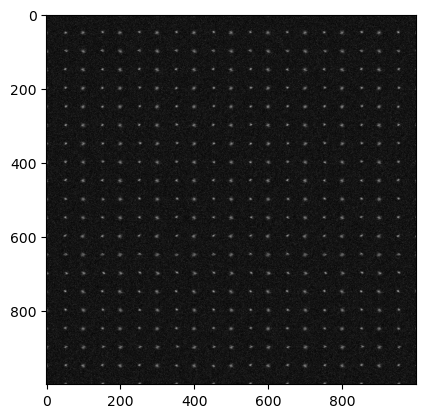

In [4]:
# The original images were classified in the folder: random-lattices
folder_path = os.path.join(os.getcwd(), "random-lattices")

# Calculate the total number of classes and images
classes = os.listdir(folder_path)

tot_number_images = 0

for each_class in classes:    
    tot_number_images += len(list(filter(lambda x: x.endswith(".png"), os.listdir(os.path.join(folder_path, each_class)))))
    
print(f"Total number of classes is {len(classes)} and total number of images is  {tot_number_images}")

# look at a random image to check
def random_image(path):
    #path=glob(train_folder+"/*/*.png")
    a=image.load_img(np.random.choice(path))
    plt.imshow(a)
    print("the size of the image is ",a.size)
    print("the maximum value in image is ",np.max(a))
    plt.show()

random_image(glob(folder_path+"/*/*.png"))

## Define some image parameters for the Model Training

In [5]:
dim1=[]
dim2=[]

for cs in os.listdir(folder_path):
    cs_path = os.path.join(folder_path, cs)
    for image_filename in os.listdir(cs_path):
        image_path = os.path.join(cs_path, image_filename)
        with Image.open(image_path) as img:    # Image.open from PIL library
            width, height = img.size
            dim1.append(width)
            dim2.append(height)
            
# We can choose the minimum image size or the average image size depends on available resources for computation
image_shape=(int(np.min(dim1)), int(np.min(dim2)))
#image_shape=(int(np.average(dim1)), int(np.average(dim2)))

image_shape

(600, 600)

**Define batch size and epochs**

In [8]:
image_size=[image_shape[0], image_shape[1]]

batch_size=32
epochs=15

## Image Augmentation

In [9]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
data_augmentation = Sequential([
                            layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                            layers.experimental.preprocessing.RandomRotation(0.2),
                            #rescaling can also be applied in ds.map()
                            layers.experimental.preprocessing.Rescaling(scale = 1/255.0)
                                ])

#Load an image using load_image
image1=load_img(np.random.choice(glob(folder_path+"/*/*.png")), target_size = (image_size[0], image_size[1]))
#convert image with size [h,w] tp an image with a shape e.g. (600, 600, 3)
image_array = img_to_array(image1)  

# Add the image to a batch with TensorShape([1, 600, 600, 3])
image = tf.cast(tf.expand_dims(image_array, 0), "float32")

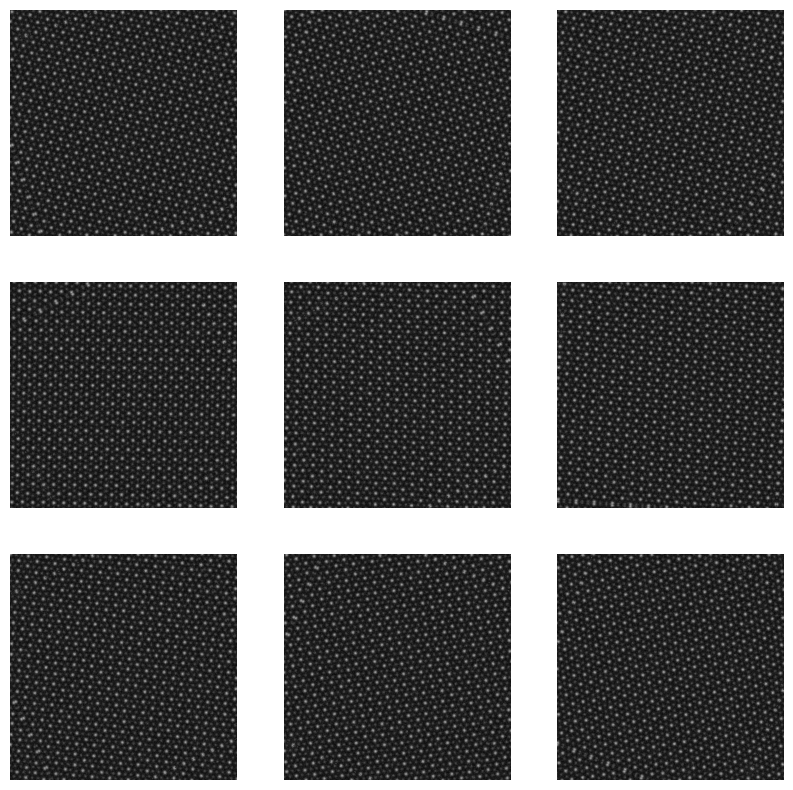

In [10]:
#Plotting a random image and apply data augmentation
plt.figure(figsize=(10,10))
for i in range(9):
    augmented_image = data_augmentation (image)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

### Apply the preprocessing layers to your dataset

In [11]:
# it yields `float32` tensors of shape `(batch_size, image_size[0], image_size[1], num_channels)`
ds_train = image_dataset_from_directory(
    directory = folder_path, 
    validation_split= 0.3, 
    subset = "training", 
    label_mode = "categorical",
    seed = 123, 
    image_size= (image_size[0], image_size[1]), 
    )   #batch_size = batch_size

# it yields `float32` tensors of shape `(batch_size, image_size[0], image_size[1], num_channels)`
ds_valid = image_dataset_from_directory(
    directory = folder_path, 
    validation_split= 0.3, 
    subset = "validation", 
    label_mode = "categorical",
    seed = 123, 
    image_size= (image_size[0], image_size[1]), 
    )   #batch_size = batch_size

Found 3064 files belonging to 13 classes.
Using 2145 files for training.
Found 3064 files belonging to 13 classes.
Using 919 files for validation.


In [12]:
train_size = len(ds_train.file_paths)
valid_size = len(ds_valid.file_paths)

ds_train.take(1)

<TakeDataset shapes: ((None, 600, 600, 3), (None, 13)), types: (tf.float32, tf.float32)>

In [13]:
it = iter(ds_train)
x, y = next(it)
print(x.shape, y.shape)

(32, 600, 600, 3) (32, 13)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare (ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    
    if shuffle:
        ds = ds.shuffle(1000)
    if augment:
        ds = ds.map(lambda x,y: (data_augmentation(x, training = True), y), num_parallel_calls = AUTOTUNE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.cache()
    ds = ds.repeat(count= 15)
    
    return ds

In [15]:
train_ds = prepare(ds_train, shuffle= True, augment= True)
train_ds

<RepeatDataset shapes: ((None, 600, 600, 3), (None, 13)), types: (tf.float32, tf.float32)>

In [16]:
valid_ds = prepare(ds_valid, shuffle= False, augment= False)
valid_ds

<RepeatDataset shapes: ((None, 600, 600, 3), (None, 13)), types: (tf.float32, tf.float32)>

labels=[None]*len(test_data_gen.class_indices)
for k,v in test_data_gen.class_indices.items():
    labels[v]=k
labels, len(labels)

## Load VGG, Define Dense Layer and Execute Model

In [18]:
# Define the available model options and get user input
options = ["full_cnn", "cnn_5_removed"]

model_name = input(f"please select a model from the list {options} \n")
title = input(f"Please choose a title for files to be save later \n")

#Load VGG parameters
vgg = VGG16(input_shape = image_size + [3], 
            weights = "imagenet",
            include_top = False
           )

for layer in vgg.layers:
    layer.trainable=False 
    
def get_num_layers(vgg, model_name):
    """ 
    This function allows one to use all layers of VGG model or drop last layer or even more. 
    I assume that I need full layers or I like to drop the last layer (5th one) 
    """
    if model_name == "full_cnn":
        
        #Define the Dense layers
        x=Flatten()(vgg.output)
        x=Dense(2048, activation="relu")(x)
        x=Dense(1024, activation="relu")(x)
        x=Dropout(0.2)(x)
        prediction=Dense(len(classes), activation="softmax")(x)
        
    elif model_name == "cnn_5_removed":
        
        #removing the layer 5 of the CNN
        layer_dict = dict([(layer.name, layer) for layer in vgg.layers])
        output_4 = layer_dict["block4_pool"].output
        vgg_2 = tf.keras.Model(inputs=vgg.input, outputs = output_4)
        x=Flatten()(vgg_2.output)  
        x=Dense(1024, activation="relu")(x)
        #x=Dense(1024, activation="relu")(x)
        #x=Dropout(0.2)(x)
        prediction=Dense(len(classes), activation="softmax")(x)
        
    else:
        raise ValueError("Invalid Model Architucture")
    return prediction

#Define the prediction 
prediction = get_num_layers(vgg, model_name)

#Pass the parameters, inputs and outputs to the VGG model
model_vgg = Model(inputs = vgg.input, outputs = prediction, )

please select a model from the list ['full_cnn', 'cnn_5_removed'] 
full_cnn
Please choose a title for files to be save later 
full_cnn_2048_1024


In [19]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 150, 150, 128)     0     

In [20]:
#A folder to save the results
folder_dest = os.path.join(os.getcwd(), "random-lattices-split")

model_vgg.compile(loss = "categorical_crossentropy", 
                  optimizer="adam", 
                  metrics = ["accuracy"])

summary_model_path = os.path.join(folder_dest, f"summary_{title}.h5")

model_vgg.save(summary_model_path)

checkpoint_filepath = os.path.join(folder_dest, f"summary_{title}.h5")

checkpoint = ModelCheckpoint(filepath = checkpoint_filepath, 
                             monitor = 'val_accuracy', 
                             verbose = 0, 
                             save_best_only = True, 
                             save_weights_only = True, 
                             mode='max')

early = EarlyStopping(monitor = 'loss', 
                      min_delta = 0, 
                      patience = 3,
                      verbose = 0, 
                      restore_best_weights = True)

In [21]:
start=time.time()

random_lattice_vgg = model_vgg.fit(
    train_ds,
    validation_data = valid_ds,
    batch_size= batch_size, 
    epochs = epochs,
    validation_steps = valid_size // batch_size,
    steps_per_epoch  = train_size // batch_size,
    callbacks = [checkpoint, early])

end=time.time()
total_time=(end-start)/60
print("total time in min is :", total_time)

Epoch 1/15
67/67 [==============================] - 39s 338ms/step - loss: 8.4629 - accuracy: 0.3284 - val_loss: 31.5657 - val_accuracy: 0.2243
Epoch 2/15
67/67 [==============================] - 22s 330ms/step - loss: 1.3432 - accuracy: 0.5367 - val_loss: 42.0792 - val_accuracy: 0.2433
Epoch 3/15
67/67 [==============================] - 22s 331ms/step - loss: 1.0477 - accuracy: 0.6133 - val_loss: 57.1812 - val_accuracy: 0.2355
Epoch 4/15
67/67 [==============================] - 22s 329ms/step - loss: 0.9050 - accuracy: 0.6621 - val_loss: 60.4031 - val_accuracy: 0.2210
Epoch 5/15
67/67 [==============================] - 22s 331ms/step - loss: 0.7757 - accuracy: 0.7004 - val_loss: 67.3860 - val_accuracy: 0.2210
Epoch 6/15
67/67 [==============================] - 22s 333ms/step - loss: 0.5884 - accuracy: 0.7572 - val_loss: 74.6392 - val_accuracy: 0.2355
Epoch 7/15
67/67 [==============================] - 22s 330ms/step - loss: 0.5569 - accuracy: 0.7733 - val_loss: 90.6665 - val_accuracy:

In [22]:
model_vgg.save(os.path.join(folder_dest, f"entire_model_{title}"
                           
                           ))
model_vgg.save(os.path.join(folder_dest, f"entire_model_{title}.h5"))

INFO:tensorflow:Assets written to: C:\Ali\ETH\ScopeM\Projects\2884_Kim_Minsoo\polarization\BTO15\Simulation\random-lattices-split\entire_model_full_cnn_2048_1024\assets


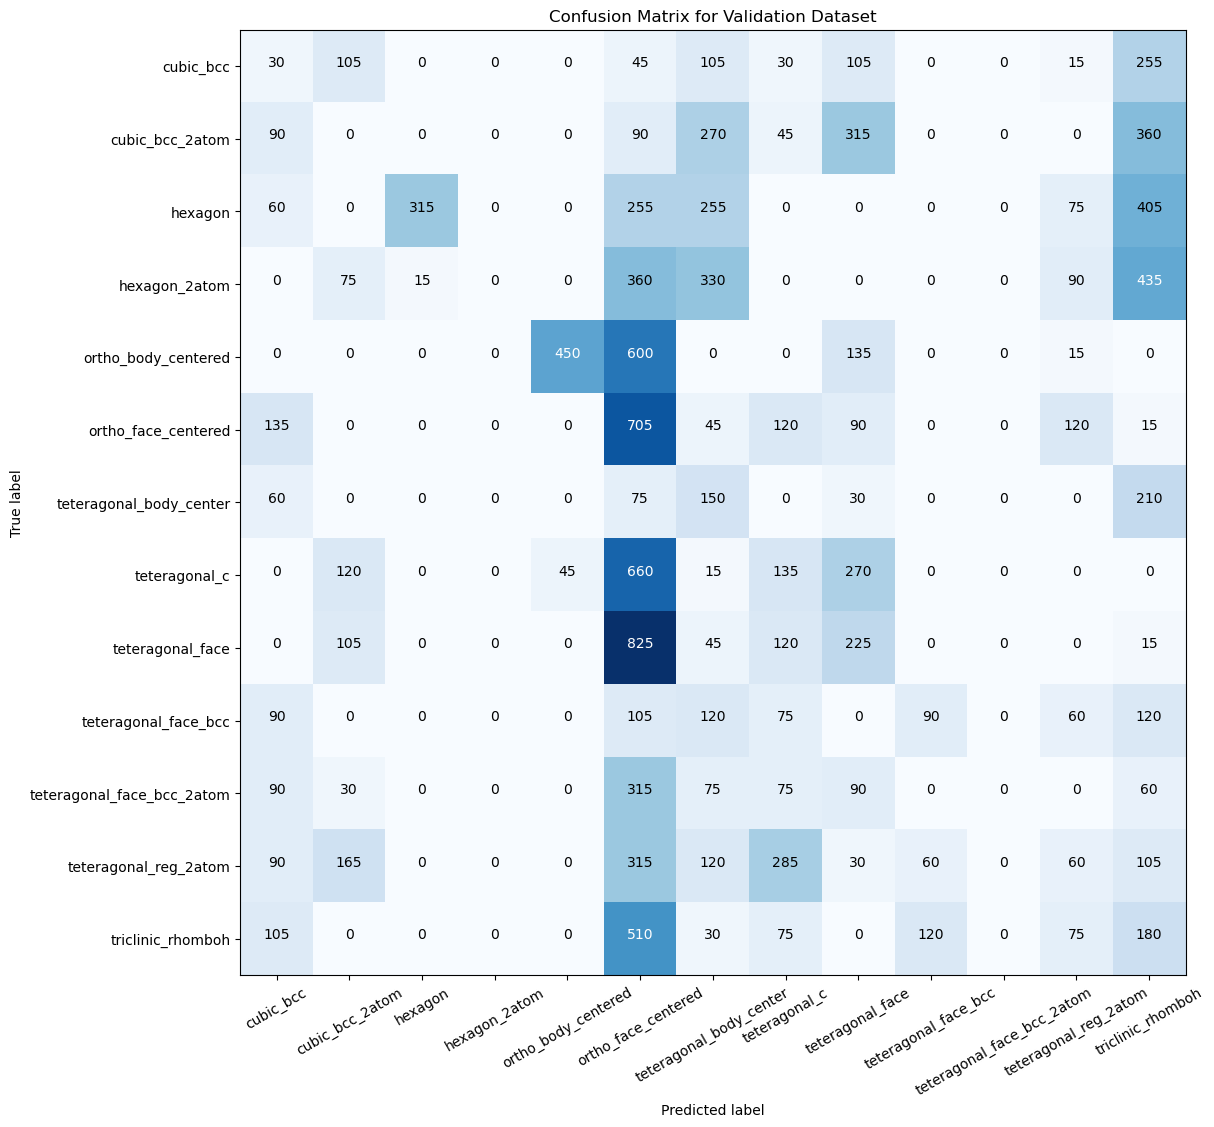

In [38]:
import itertools

# Get the predicted labels for the validation set
predicted_label = model_vgg.predict(valid_ds)

# Get the true labels for the validation set
true_label = np.concatenate([y for x, y in valid_ds], axis=0)
#labels are one hot encoded, so convert them into the integers for confusion matrix
true_label = np.argmax(true_label , axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(true_label , predicted_label.argmax(axis=-1))

# Define the class names
class_names = ds_valid.class_names

# Plot the confusion matrix
plt.figure(figsize = (12, 12))
plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Confusion Matrix for Validation Dataset')
#plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation = 30)
plt.yticks(tick_marks, class_names)

# Plot the values in each cell
threshold = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   #cm.shape e.g. len(class_names)
    plt.text(j, i, cm[i, j],
             horizontalalignment = "center",
             color = "white" if cm[i, j] > threshold else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel("Predicted label")
plt.tick_params(axis = "x", which = "major")
plt.show()


In [36]:
# Another attempt

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in ds_valid:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_vgg.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

print(confusion_matrix(np.argmax(correct_labels, axis = -1), predicted_labels))

[[ 2  7  0  0  0  3  7  2  7  0  0  1 17]
 [ 6  0  0  0  0  6 18  3 21  0  0  0 24]
 [ 4  0 21  0  0 17 17  0  0  0  0  5 27]
 [ 0  5  1  0  0 24 22  0  0  0  0  6 29]
 [ 0  0  0  0 30 40  0  0  9  0  0  1  0]
 [ 9  0  0  0  0 47  3  8  6  0  0  8  1]
 [ 4  0  0  0  0  5 10  0  2  0  0  0 14]
 [ 0  8  0  0  3 44  1  9 18  0  0  0  0]
 [ 0  7  0  0  0 55  3  8 15  0  0  0  1]
 [ 6  0  0  0  0  7  8  5  0  6  0  4  8]
 [ 6  2  0  0  0 21  5  5  6  0  0  0  4]
 [ 6 11  0  0  0 21  8 19  2  4  0  4  7]
 [ 7  0  0  0  0 34  2  5  0  8  0  5 12]]


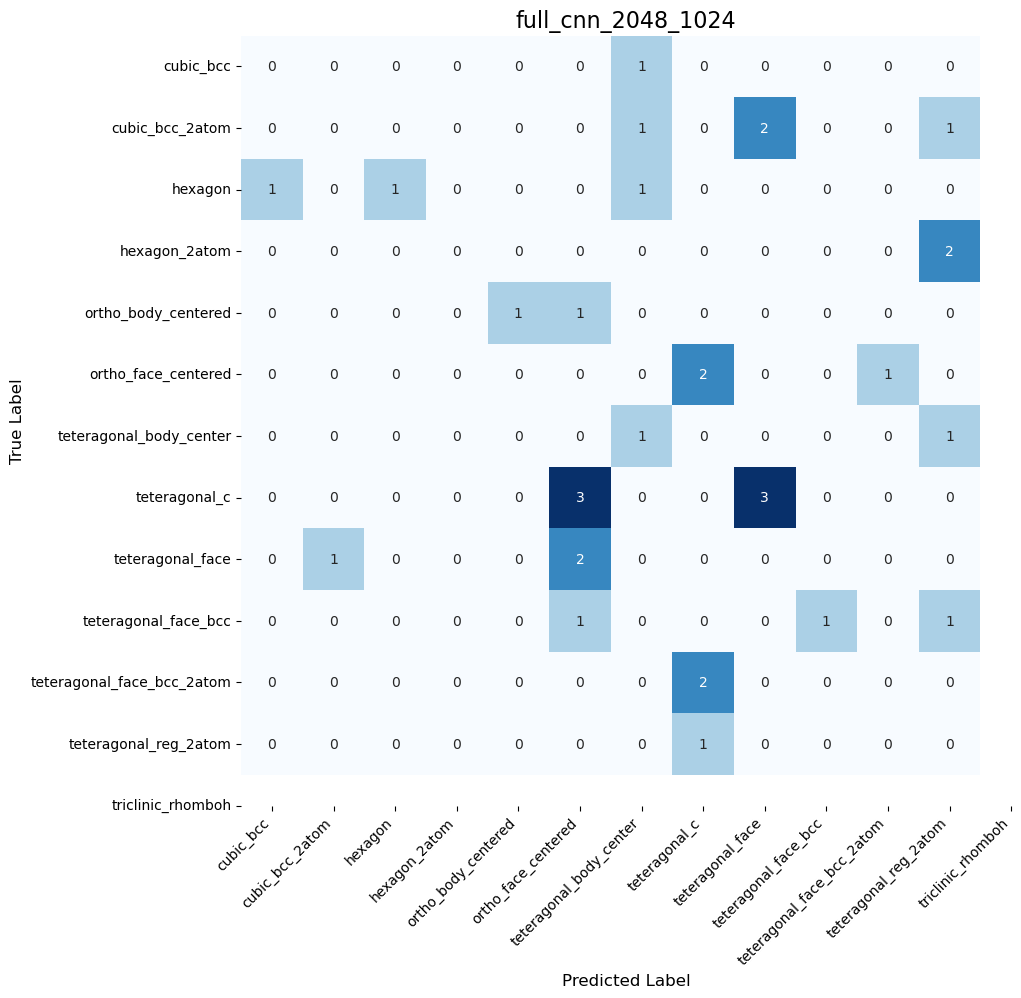

In [26]:
#Plot confusion matrix for test data (here is validation dataset, but it should be done on test dataset)

#First: get the predicted and true labels in e.g. validation dataset
for image, label in valid_ds.take(1):
    #return the last index, class, with highest probability
    predicted_label = np.argmax(model_vgg.predict(image), axis = -1) 
    
    true_label = np.argmax(label, axis = -1)
    
# Get the names of the classes
class_names =  ds_valid.class_names

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    """ A function to get predicted and true y labels and plot a heatmap (from seaborn) of true prediction """
    cm = confusion_matrix(y_true, y_pred)
    heatmap(
            cm, 
            annot = True, 
            square= True, 
            xticklabels = class_names, 
            yticklabels = class_names,
            fmt  = "d", 
            cmap = plt.cm.Blues,
            cbar = False, 
            ax = ax
            )
    ax.set_title(title, fontsize = 16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel("True Label", fontsize = 12)
    ax.set_xlabel("Predicted Label", fontsize = 12)

fig, ax1 = plt.subplots(1, 1, figsize = (15, 10))
plot_heatmap(true_label, predicted_label, class_names, ax1, title=title)    
#plt.savefig(folder_dest + title + "_confusion_plot.png", bbox_inches = "tight")

## Plot Metrics and Confusion Matrix

In [25]:
#Plot confusion matrix for test data (here is validation dataset, but it should be done on test dataset)
confusion_plot = model_vgg.predict(valid_ds)
confusion_plot_classes=np.argmax(confusion_plot, axis=1)

# Get the names of the classes
#class_names = test_data_gen.class_indices.keys()
class_names =  ds_valid.class_names
true_classes = test_data_gen.classes

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    """ A function to get predicted and true y labels and plot a heatmap (from seaborn) of true prediction """
    cm = confusion_matrix(y_true, y_pred)
    heatmap(
            cm, 
            annot = True, 
            square= True, 
            xticklabels = class_names, 
            yticklabels = class_names,
            fmt  = "d", 
            cmap = plt.cm.Blues,
            cbar = False, 
            ax = ax
            )
    ax.set_title(title, fontsize = 16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel("True Label", fontsize = 12)
    ax.set_xlabel("Predicted Label", fontsize = 12)

fig, ax1 = plt.subplots(1, 1, figsize = (15, 10))
plot_heatmap(true_classes, confusion_plot_classes, class_names, ax1, title=title)    
plt.savefig(folder_dest + title + "_confusion_plot.png", bbox_inches = "tight")

NameError: name 'test_data_gen' is not defined

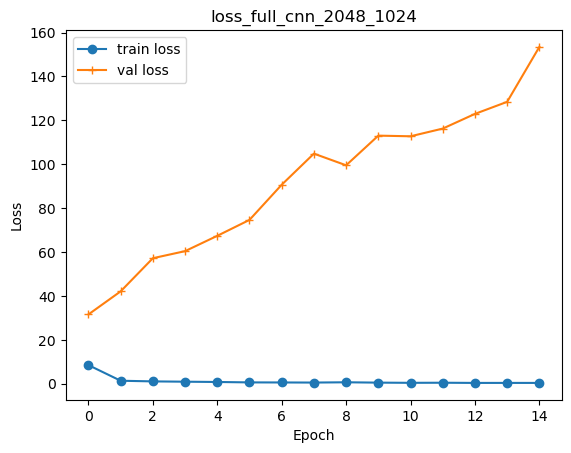

In [27]:
# Plot Loss
history = random_lattice_vgg.history
plt.plot(history["loss"],   label = "train loss", marker = "o")
plt.plot(history["val_loss"], label = "val loss", marker = "+")
plt.legend()
plt.title(f"loss_{title}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(folder_dest + title + "_loss.png", dpi=300, bbox_inches='tight')
plt.show()

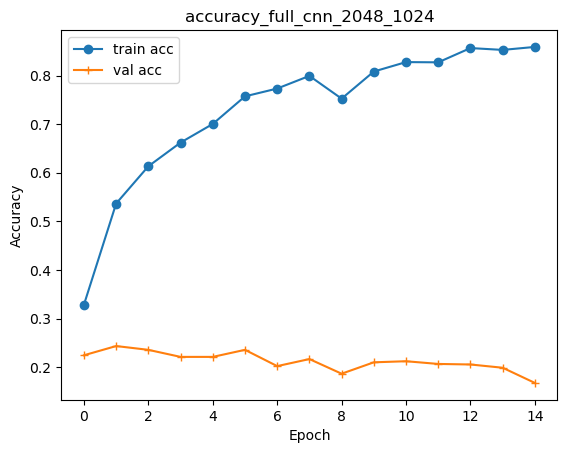

In [28]:
# Plot Accuracy
plt.plot(history["accuracy"],   label = "train acc", marker = "o")
plt.plot(history["val_accuracy"], label = "val acc", marker = "+")
plt.legend()
plt.title(f"accuracy_{title}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(folder_dest+title+"_accuracy.png", dpi=300, bbox_inches='tight')
plt.show()

In [30]:
#Calculate the score of train and valid sets and make a table
score_valid=model_vgg.evaluate(valid_ds, batch_size = batch_size, return_dict=True)
score_train=model_vgg.evaluate(train_ds, batch_size = batch_size, return_dict=True)

score_eval = pd.DataFrame({"score_valid" : score_valid, "score_train": score_train})
score_eval.to_csv(folder_dest + f"score evaluation {title}")
score_eval

1020/1020 [==============================] - 216s 212ms/step - loss: 0.4030 - accuracy: 0.8438


,score_valid,score_train
loss,152.861572,0.402982
accuracy,0.169750,0.843823


In [ ]:
def get_confusion_matrix(data_path, N):
    """ A function to plot confus"""
   
    predictions=[]
    targets=[]
   
    for x, y in gen_vgg.flow_from_directory(data_path, target_size=image_size, shuffle=False, batch_size=batch_size):
       # here x is input ata and y is class labels
        p = model_vgg.predict(x).argmax(axis = 1) #we need num_class=1 for confusion matrix, so we use argmax
        y = y.argmax(axis=1)                      # array for target, labels form a 1D array
        predictions.extend (p)
        targets.extend(y)
        
        #flow_from_directory never ends, we have to break it.
        if len(targets) >= N:
            break
    cm = confusion_matrix(targets, predictions)
    return cm

cm_train_2 = get_confusion_matrix(train_folder, train_size)
cm_valid_2 = get_confusion_matrix(valid_folder, valid_size)
print("train matrix", cm_train_2)
print("")
print("valid matrix", cm_valid_2)

## Prediction

In [ ]:
def get_random_image (image_dir, image_size):
    """ A function to load and display a random image from a specified directory
        image_dir (str): e.g. train_folder, valid_folder etc
        image_size (list int): e.g. [600, 600] 
    """
    
    # Choose a random class (label) from available classes
    random_class=np.random.choice(os.listdir(image_dir))
    
    # Select a random image from chosen class
    random_img=np.random.choice(glob(os.path.join(image_dir, random_class, "*.png")))
    
    #Load and display image
    img=image.load_img((random_img), 
                       target_size = (image_size[0], image_size[1])
                      )
    plt.imshow(img)
    plt.show()
    
    #Convert the loaded image to a format which is suitable for the model
    img_array = image.img_to_array(img)
    img_array = img_array.reshape (1, *img_array.shape) / 255.0
    
    return img_array, random_class
   
def check_image(title, img_size):
    """ A function to load a saved model, select and display a random image, and predict its class """
    
    # Load a saved model
    model = load_model(os.path.join(folder_dest, f"entire_model_{title}")) 
    
    # Load and dispaly a random image
    img_array, random_class = get_random_image(train_folder, image_size)
    
    #Predict the class of the image
    output = np.argmax(model_pred.class_indices(img_array), axis = -1)
    
    #Check if the predicted class is the same as the real class
    real_class_index = tet_data_gen.class_indices[random_class]
    predicted_class_index = np.argmax(output)
    predicted_class= list(test_data_gen.class_indices.keys())[predicted_class_index]
          
    if predicted_class_index == real_class_index:
        print("real class and the predicted class are both ", random_class)
    else:
        print("real class is ", random_class," but predicted class is ", predicted_class )

In [ ]:
check_image(title, 700)

# Visualizing what convnets learn


In [ ]:
# load the model
model2 = VGG16()
# summarize filter shapes
for layer in model2.layers:

    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model2.layers[1].get_weights()
biases[0:9]

In [ ]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
filters.shape

In [ ]:
# plot  filters
filters, biases = model2.layers[1].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 6, 1
for i in range(n_filters):
    
     # get the filter
    f = filters[:, :, :, i]
     # plot each channel separately
    for j in range(3):
        #specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
plt.show()

### How to Visualize Feature Maps

In [ ]:
# redefine model to output right after the first hidden layer
model2= VGG16(input_shape=image_size+[3], weights="imagenet", include_top=False)

model2 = Model(inputs=model2.inputs, outputs=model2.layers[16].output)
print(model2.output_names)

In [ ]:
os.makedirs(folder_dest+"/feature maps/",exist_ok=True )

In [ ]:
folder_map=folder_dest+"/feature maps"

# redefine model to output right after the first hidden layer
model2= VGG16(input_shape=image_size+[3], weights="imagenet", include_top=False)

model2 = Model(inputs=model2.inputs, outputs=model2.layers[17].output)
layer_title=model2.output_names

layer_title="".join(layer_title)

# load the image with the required shape, a random image from a random class

#random_class=np.random.choice(os.listdir(train_folder))
#random_image=np.random.choice(glob(train_folder+"/"+random_class+"/*.png"))

random_class= os.listdir(train_folder)[5]
random_image=glob(train_folder+"/"+random_class+"/*.png")[100]


image_class=random_class.split("\\")[-1]
image_title=random_image.split("\\")[-1]

img = image.load_img(random_image, target_size=(image_size[0], image_size[1]))

plt.imshow(img)
plt.title(f"random_image {image_title} from class {image_class}")
plt.savefig(folder_map+"/"+f"{layer_title} {image_title}.png")

img = image.img_to_array(img) # convert the image to an array
img = np.expand_dims(img, axis=0) # expand dimensions so that it represents a single 'sample'  (1, 600, 600, 3)
img = preprocess_input(img) # prepare the image (e.g. scale pixel values for the vgg)  max=145.061

# get feature map for first hidden layer
feature_maps = model2.predict(img)   #(1, 600, 600, 64)

# plot all 64 maps in an 8x8 squares
plt.figure(figsize=(16,16))
square =4 
ix = 1
for _ in range(square):   #underscore is like iterator when the interator is not used in code
    
    #
     for _ in range(square):
        #
         # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"{layer_title} and filter number {ix}")
         # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        
        
        ix += 1
      
plt.savefig(folder_map+"/"+f"{layer_title} {image_title} {square}.png")
#plt.title(f"{layer_title} and number of filters {square}")
#plt.suptitle(f"{layer_title} and number of filters {square}")

# show the figure
plt.show()